# _**Bibliotecas python**_

## Instalação de pacotes

In [ ]:
!pip show statsmodels

Name: statsmodels
Version: 0.10.2
Summary: Statistical computations and models for Python
Home-page: https://www.statsmodels.org/
Author: None
Author-email: None
License: BSD License
Location: /usr/local/lib/python3.7/dist-packages
Requires: patsy, pandas, numpy, scipy
Required-by: plotnine


In [ ]:
# Atualizando o pacote statsmodels para a versão 0.12.2 para a qual aplicamos o SEASONAL DECOMPOSE
!pip install statsmodels==0.12.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.5 MB 7.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
!pip show statsmodels

Name: statsmodels
Version: 0.12.2
Summary: Statistical computations and models for Python
Home-page: https://www.statsmodels.org/
Author: None
Author-email: None
License: BSD License
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy, pandas, scipy, patsy
Required-by: plotnine


In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 26.0 MB/s 


In [ ]:
!pip show pmdarima

Name: pmdarima
Version: 1.8.5
Summary: Python's forecast::auto.arima equivalent
Home-page: http://alkaline-ml.com/pmdarima
Author: None
Author-email: None
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: statsmodels, urllib3, pandas, joblib, scikit-learn, setuptools, Cython, scipy, numpy
Required-by: 


## Importação de Bibliotecas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Vinculando endereços de drive para query
path = '/content/drive/My Drive/USP/TCC/Database/'
file1 = 'BackUp of CSV_deliveries.csv'
file2 = 'CSV_production.csv'

Mounted at /content/drive


In [ ]:
# Importanto as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importando pacotes necessários
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.forecasting.theta import ThetaModel
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from matplotlib import pyplot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
%matplotlib inline

# Ignorar mensagens de erro
import warnings
warnings.filterwarnings('ignore')

# Definindo o tamanho e estilo dos gráficos
plt.rc("figure",figsize=(15,8))
plt.rc("font",size=15)
plt.rc("lines",linewidth=2)
sns.set_style("whitegrid")

# _**Base de dados**_

### Leitura de DataFrames

In [ ]:
## Importação da base de dados de entregas (CSV_deliveries.csv) do ORACLE
df1 = pd.read_csv(path+file1)
df1['Deliveries'].fillna(0,inplace=True)

## Dataframe global
df1['Date'] = pd.to_datetime(df1['Date'])
dm1 = df1.groupby(pd.Grouper(key='Date', freq='M'))['Deliveries'].sum()
#dm.index = dm.index.strftime('%B')
dm1 = pd.DataFrame(dm1)

## Plotar as entregas mensais
sns.set_style('ticks')
mDeliveries = sns.lineplot(data = dm1, x=dm1.index, y = dm1['Deliveries'], color = 'green')
mDeliveries.set_title('Volume de Entregas Mensais (em toneladas)', fontsize = 15)
mDeliveries.set_ylabel('Entregas (ton)', fontsize = 13)
mDeliveries.set_xlabel('Meses', fontsize = 13)
plt.show()

In [ ]:
## Importação da base de dados de entregas (CSV_production.csv) do ORACLE
df2 = pd.read_csv(path+file2)
df2['Quantity'].fillna(0,inplace=True)

## Dataframe global
df2['Date'] = pd.to_datetime(df2['Date'])
dm2 = df2.groupby(pd.Grouper(key='Date', freq='M'))['Quantity'].sum()
#dm2.index = dm2.index.strftime('%B')
dm2 = pd.DataFrame(dm2)

## Plotar as entregas mensais
sns.set_style('ticks')
mProduction = sns.lineplot(data = dm2, x=dm2.index, y = dm2['Quantity'], color = 'blue')
mProduction.set_title('Produção Mensal (em toneladas)', fontsize = 15)
mProduction.set_ylabel('Produção (ton)', fontsize = 13)
mProduction.set_xlabel('Meses', fontsize = 13)
plt.show()

### Dataframes de Entregas

In [ ]:
# CSV_deliveries.csv
# Fazendo tratamento da base de entregas (faturamento) para criar DataFrames para cada unidade produtora

# Criando dataframes para Porto Nacional

df1_PNO = df1[(df1['pUnit'] == 'PNO')]

dm1_PNO = df1_PNO.copy()
dm1_PNO['Date'] = pd.to_datetime(df1_PNO['Date'])
dm1_PNO = df1_PNO.groupby(pd.Grouper(key='Date', freq='M'))['Deliveries'].sum()
#dm.index = dm.index.strftime('%B')
dm1_PNO = pd.DataFrame(dm1_PNO)

df1_PNO = df1_PNO.groupby(by='Date',as_index=False)['Deliveries'].sum()
mask_PNO = df1[(df1['pUnit'].isnull())].drop(['bUnit','pUnit','Regional'],axis='columns')
df1_PNO = df1_PNO.append(mask_PNO)
df1_PNO['Date'] = pd.to_datetime(df1_PNO['Date'])
df1_PNO = df1_PNO.set_index('Date').sort_index(axis = 0)

idx = pd.date_range(start = df1_PNO.index.min(), end = df1_PNO.index.max(), freq='D')
df1_PNO = df1_PNO.reindex(idx)

df1_PNO[df1_PNO['Deliveries'] < 0] = 0
df1_PNO = df1_PNO.fillna(0)

# Criando dataframes para São Luís

df1_SLO = df1[(df1['pUnit'] == 'SLO')]

dm1_SLO = df1_SLO.copy()
dm1_SLO['Date'] = pd.to_datetime(df1_SLO['Date'])
dm1_SLO = df1_SLO.groupby(pd.Grouper(key='Date', freq='M'))['Deliveries'].sum()
#dm.index = dm.index.strftime('%B')
dm1_SLO = pd.DataFrame(dm1_SLO)

df1_SLO = df1_SLO.groupby(by='Date',as_index=False)['Deliveries'].sum()
mask_SLO = df1[(df1['pUnit'].isnull())].drop(['bUnit','pUnit','Regional'],axis='columns')
df1_SLO = df1_SLO.append(mask_SLO)
df1_SLO['Date'] = pd.to_datetime(df1_SLO['Date'])
df1_SLO = df1_SLO.set_index('Date').sort_index(axis = 0)

idx = pd.date_range(start = df1_SLO.index.min(), end = df1_SLO.index.max(), freq='D')
df1_SLO = df1_SLO.reindex(idx)

df1_SLO[df1_SLO['Deliveries'] < 0] = 0
df1_SLO = df1_SLO.fillna(0)

# Criando dataframes para Querência

df1_QRO = df1[(df1['pUnit'] == 'QRO')]

dm1_QRO = df1_QRO.copy()
dm1_QRO['Date'] = pd.to_datetime(df1_QRO['Date'])
dm1_QRO = df1_QRO.groupby(pd.Grouper(key='Date', freq='M'))['Deliveries'].sum()
#dm.index = dm.index.strftime('%B')
dm1_QRO = pd.DataFrame(dm1_QRO)

df1_QRO = df1_QRO.groupby(by='Date',as_index=False)['Deliveries'].sum()
mask_QRO = df1[(df1['pUnit'].isnull())].drop(['bUnit','pUnit','Regional'],axis='columns')
df1_QRO = df1_QRO.append(mask_QRO)
df1_QRO['Date'] = pd.to_datetime(df1_QRO['Date'])
df1_QRO = df1_QRO.set_index('Date').sort_index(axis = 0)

idx = pd.date_range(start = df1_QRO.index.min(), end = df1_QRO.index.max(), freq='D')
df1_QRO = df1_QRO.reindex(idx)

df1_QRO[df1_QRO['Deliveries'] < 0] = 0
df1_QRO = df1_QRO.fillna(0)

# Criando dataframes para Barcarena

df1_BCO = df1[(df1['pUnit'] == 'BCO')]

dm1_BCO = df1_BCO.copy()
dm1_BCO['Date'] = pd.to_datetime(df1_BCO['Date'])
dm1_BCO = df1_BCO.groupby(pd.Grouper(key='Date', freq='M'))['Deliveries'].sum()
#dm.index = dm.index.strftime('%B')
dm1_BCO = pd.DataFrame(dm1_BCO)

df1_BCO = df1_BCO.groupby(by='Date',as_index=False)['Deliveries'].sum()
mask_BCO = df1[(df1['pUnit'].isnull())].drop(['bUnit','pUnit','Regional'],axis='columns')
df1_BCO = df1_BCO.append(mask_BCO)
df1_BCO['Date'] = pd.to_datetime(df1_BCO['Date'])
df1_BCO = df1_BCO.set_index('Date').sort_index(axis = 0)

idx = pd.date_range(start = df1_BCO.index.min(), end = df1_BCO.index.max(), freq='D')
df1_BCO = df1_BCO.reindex(idx)

df1_BCO[df1_BCO['Deliveries'] < 0] = 0
df1_BCO = df1_BCO.fillna(0)

# Criando dataframes para Fertimaxi

df1_FTX = df1[(df1['pUnit'] == 'FTX')]

dm1_FTX = df1_FTX.copy()
dm1_FTX['Date'] = pd.to_datetime(df1_FTX['Date'])
dm1_FTX = df1_FTX.groupby(pd.Grouper(key='Date', freq='M'))['Deliveries'].sum()
#dm.index = dm.index.strftime('%B')
dm1_FTX = pd.DataFrame(dm1_FTX)

df1_FTX = df1_FTX.groupby(by='Date',as_index=False)['Deliveries'].sum()
mask_FTX = df1[(df1['pUnit'].isnull())].drop(['bUnit','pUnit','Regional'],axis='columns')
df1_FTX = df1_FTX.append(mask_FTX)
df1_FTX['Date'] = pd.to_datetime(df1_FTX['Date'])
df1_FTX = df1_FTX.set_index('Date').sort_index(axis = 0)

idx = pd.date_range(start = df1_FTX.index.min(), end = df1_FTX.index.max(), freq='D')
df1_FTX = df1_FTX.reindex(idx)

df1_FTX[df1_FTX['Deliveries'] < 0] = 0
df1_FTX = df1_FTX.fillna(0)

# Criando dataframes para Intermarítima

df1_INT = df1[(df1['pUnit'] == 'INT')]

dm1_INT = df1_INT.copy()
dm1_INT['Date'] = pd.to_datetime(df1_INT['Date'])
dm1_INT = df1_INT.groupby(pd.Grouper(key='Date', freq='M'))['Deliveries'].sum()
#dm.index = dm.index.strftime('%B')
dm1_INT = pd.DataFrame(dm1_INT)

df1_INT = df1_INT.groupby(by='Date',as_index=False)['Deliveries'].sum()
mask_INT = df1[(df1['pUnit'].isnull())].drop(['bUnit','pUnit','Regional'],axis='columns')
df1_INT = df1_INT.append(mask_INT)
df1_INT['Date'] = pd.to_datetime(df1_INT['Date'])
df1_INT = df1_INT.set_index('Date').sort_index(axis = 0)

idx = pd.date_range(start = df1_INT.index.min(), end = df1_INT.index.max(), freq='D')
df1_INT = df1_INT.reindex(idx)

df1_INT[df1_INT['Deliveries'] < 0] = 0
df1_INT = df1_INT.fillna(0)

# Criando dataframes para Sinop

df1_SNO = df1[(df1['pUnit'] == 'SNO')]

dm1_SNO = df1_SNO.copy()
dm1_SNO['Date'] = pd.to_datetime(df1_SNO['Date'])
dm1_SNO = df1_SNO.groupby(pd.Grouper(key='Date', freq='M'))['Deliveries'].sum()
#dm.index = dm.index.strftime('%B')
dm1_SNO = pd.DataFrame(dm1_SNO)

df1_SNO = df1_SNO.groupby(by='Date',as_index=False)['Deliveries'].sum()
mask_SNO = df1[(df1['pUnit'].isnull())].drop(['bUnit','pUnit','Regional'],axis='columns')
df1_SNO = df1_SNO.append(mask_SNO)
df1_SNO['Date'] = pd.to_datetime(df1_SNO['Date'])
df1_SNO = df1_SNO.set_index('Date').sort_index(axis = 0)

idx = pd.date_range(start = df1_SNO.index.min(), end = df1_SNO.index.max(), freq='D')
df1_SNO = df1_SNO.reindex(idx)

df1_SNO[df1_SNO['Deliveries'] < 0] = 0
df1_SNO = df1_SNO.fillna(0)

# Criando dataframes para Rondonópolis

df1_RNO = df1[(df1['pUnit'] == 'RNO')]

dm1_RNO = df1_RNO.copy()
dm1_RNO['Date'] = pd.to_datetime(df1_RNO['Date'])
dm1_RNO = df1_RNO.groupby(pd.Grouper(key='Date', freq='M'))['Deliveries'].sum()
#dm.index = dm.index.strftime('%B')
dm1_RNO = pd.DataFrame(dm1_RNO)

df1_RNO = df1_RNO.groupby(by='Date',as_index=False)['Deliveries'].sum()
mask_RNO = df1[(df1['pUnit'].isnull())].drop(['bUnit','pUnit','Regional'],axis='columns')
df1_RNO = df1_RNO.append(mask_RNO)
df1_RNO['Date'] = pd.to_datetime(df1_RNO['Date'])
df1_RNO = df1_RNO.set_index('Date').sort_index(axis = 0)

idx = pd.date_range(start = df1_RNO.index.min(), end = df1_RNO.index.max(), freq='D')
df1_RNO = df1_RNO.reindex(idx)

df1_RNO[df1_RNO['Deliveries'] < 0] = 0
df1_RNO = df1_RNO.fillna(0)

# Criando dataframes para Catalão

df1_CTO = df1[(df1['pUnit'] == 'CTO')]

dm1_CTO = df1_CTO.copy()
dm1_CTO['Date'] = pd.to_datetime(df1_CTO['Date'])
dm1_CTO = df1_CTO.groupby(pd.Grouper(key='Date', freq='M'))['Deliveries'].sum()
#dm.index = dm.index.strftime('%B')
dm1_CTO = pd.DataFrame(dm1_CTO)

df1_CTO = df1_CTO.groupby(by='Date',as_index=False)['Deliveries'].sum()
mask_CTO = df1[(df1['pUnit'].isnull())].drop(['bUnit','pUnit','Regional'],axis='columns')
df1_CTO = df1_CTO.append(mask_CTO)
df1_CTO['Date'] = pd.to_datetime(df1_CTO['Date'])
df1_CTO = df1_CTO.set_index('Date').sort_index(axis = 0)

idx = pd.date_range(start = df1_CTO.index.min(), end = df1_CTO.index.max(), freq='D')
df1_CTO = df1_CTO.reindex(idx)

df1_CTO[df1_CTO['Deliveries'] < 0] = 0
df1_CTO = df1_CTO.fillna(0)

# Criando dataframes para Paranaguá

df1_PGU = df1[(df1['pUnit'] == 'PGU')]

dm1_PGU = df1_PGU.copy()
dm1_PGU['Date'] = pd.to_datetime(df1_PGU['Date'])
dm1_PGU = df1_PGU.groupby(pd.Grouper(key='Date', freq='M'))['Deliveries'].sum()
#dm.index = dm.index.strftime('%B')
dm1_PGU = pd.DataFrame(dm1_PGU)

df1_PGU = df1_PGU.groupby(by='Date',as_index=False)['Deliveries'].sum()
mask_PGU = df1[(df1['pUnit'].isnull())].drop(['bUnit','pUnit','Regional'],axis='columns')
df1_PGU = df1_PGU.append(mask_PGU)
df1_PGU['Date'] = pd.to_datetime(df1_PGU['Date'])
df1_PGU = df1_PGU.set_index('Date').sort_index(axis = 0)

idx = pd.date_range(start = df1_PGU.index.min(), end = df1_PGU.index.max(), freq='D')
df1_PGU = df1_PGU.reindex(idx)

df1_PGU[df1_PGU['Deliveries'] < 0] = 0
df1_PGU = df1_PGU.fillna(0)

# Criando dataframes para Araguari

df1_ARO = df1[(df1['pUnit'] == 'ARO')]

dm1_ARO = df1_ARO.copy()
dm1_ARO['Date'] = pd.to_datetime(df1_ARO['Date'])
dm1_ARO = df1_ARO.groupby(pd.Grouper(key='Date', freq='M'))['Deliveries'].sum()
#dm.index = dm.index.strftime('%B')
dm1_ARO = pd.DataFrame(dm1_ARO)

df1_ARO = df1_ARO.groupby(by='Date',as_index=False)['Deliveries'].sum()
mask_ARO = df1[(df1['pUnit'].isnull())].drop(['bUnit','pUnit','Regional'],axis='columns')
df1_ARO = df1_ARO.append(mask_ARO)
df1_ARO['Date'] = pd.to_datetime(df1_ARO['Date'])
df1_ARO = df1_ARO.set_index('Date').sort_index(axis = 0)

idx = pd.date_range(start = df1_ARO.index.min(), end = df1_ARO.index.max(), freq='D')
df1_ARO = df1_ARO.reindex(idx)

df1_ARO[df1_ARO['Deliveries'] < 0] = 0
df1_ARO = df1_ARO.fillna(0)

In [ ]:
df1 = df1.groupby(by='Date',as_index=False)['Deliveries'].sum()
df1['Date'] = pd.to_datetime(df1['Date'])
df1= df1.set_index('Date').sort_index(axis = 0)

### Dataframes de Produção

In [ ]:
## Definir quais são as Matérias-Primas de interesse
MP1 = 'KCL'
MP2 = 'UREIA'
MP3 = 'MAP'
MP4 = 'TSP'
MP5 = 'SSP'

In [ ]:
# CSV_prodution.csv
# Fazendo tratamento da base de produção (consumo de matéria-prima) para criar DataFrames para cada unidade produtora


# Criando DataFrames para Porto Nacional
df2_PNO = df2[(df2['pUnit'] == 'PNO')]
df2_PNO_MP1 = df2_PNO[(df2_PNO['ProductGenDesc'] == MP1)]
df2_PNO_MP2 = df2_PNO[(df2_PNO['ProductGenDesc'] == MP2)]
df2_PNO_MP3 = df2_PNO[(df2_PNO['ProductGenDesc'] == MP3)]
df2_PNO_MP4 = df2_PNO[(df2_PNO['ProductGenDesc'] == MP4)]
df2_PNO_MP5 = df2_PNO[(df2_PNO['ProductGenDesc'] == MP5)]

dm2_PNO_MP1 = df2_PNO_MP1.copy()
dm2_PNO_MP1 = dm2_PNO_MP1.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_PNO_MP1 = pd.DataFrame(dm2_PNO_MP1)
df2_PNO_MP1 = df2_PNO_MP1.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_PNO_MP1 = pd.DataFrame(df2_PNO_MP1)

dm2_PNO_MP2 = df2_PNO_MP2.copy()
dm2_PNO_MP2 = dm2_PNO_MP2.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_PNO_MP2 = pd.DataFrame(dm2_PNO_MP2)
df2_PNO_MP2 = df2_PNO_MP2.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_PNO_MP2 = pd.DataFrame(df2_PNO_MP2)

dm2_PNO_MP3 = df2_PNO_MP3.copy()
dm2_PNO_MP3 = dm2_PNO_MP3.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_PNO_MP3 = pd.DataFrame(dm2_PNO_MP3)
df2_PNO_MP3 = df2_PNO_MP3.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_PNO_MP3 = pd.DataFrame(df2_PNO_MP3)

dm2_PNO_MP4 = df2_PNO_MP4.copy()
dm2_PNO_MP4 = dm2_PNO_MP4.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_PNO_MP4 = pd.DataFrame(dm2_PNO_MP4)
df2_PNO_MP4 = df2_PNO_MP4.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_PNO_MP4 = pd.DataFrame(df2_PNO_MP4)

dm2_PNO_MP5 = df2_PNO_MP5.copy()
dm2_PNO_MP5 = dm2_PNO_MP5.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_PNO_MP5 = pd.DataFrame(dm2_PNO_MP5)
df2_PNO_MP5 = df2_PNO_MP5.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_PNO_MP5 = pd.DataFrame(df2_PNO_MP5)

# Criando DataFrames para São Luís
df2_SLO = df2[(df2['pUnit'] == 'SLO')]
df2_SLO_MP1 = df2_SLO[(df2_SLO['ProductGenDesc'] == MP1)]
df2_SLO_MP2 = df2_SLO[(df2_SLO['ProductGenDesc'] == MP2)]
df2_SLO_MP3 = df2_SLO[(df2_SLO['ProductGenDesc'] == MP3)]
df2_SLO_MP4 = df2_SLO[(df2_SLO['ProductGenDesc'] == MP4)]
df2_SLO_MP5 = df2_SLO[(df2_SLO['ProductGenDesc'] == MP5)]

dm2_SLO_MP1 = df2_SLO_MP1.copy()
dm2_SLO_MP1 = dm2_SLO_MP1.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_SLO_MP1 = pd.DataFrame(dm2_SLO_MP1)
df2_SLO_MP1 = df2_SLO_MP1.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_SLO_MP1 = pd.DataFrame(df2_SLO_MP1)

dm2_SLO_MP2 = df2_SLO_MP2.copy()
dm2_SLO_MP2 = dm2_SLO_MP2.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_SLO_MP2 = pd.DataFrame(dm2_SLO_MP2)
df2_SLO_MP2 = df2_SLO_MP2.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_SLO_MP2 = pd.DataFrame(df2_SLO_MP2)

dm2_SLO_MP3 = df2_SLO_MP3.copy()
dm2_SLO_MP3 = dm2_SLO_MP3.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_SLO_MP3 = pd.DataFrame(dm2_SLO_MP3)
df2_SLO_MP3 = df2_SLO_MP3.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_SLO_MP3 = pd.DataFrame(df2_SLO_MP3)

dm2_SLO_MP4 = df2_SLO_MP4.copy()
dm2_SLO_MP4 = dm2_SLO_MP4.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_SLO_MP4 = pd.DataFrame(dm2_SLO_MP4)
df2_SLO_MP4 = df2_SLO_MP4.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_SLO_MP4 = pd.DataFrame(df2_SLO_MP4)

dm2_SLO_MP5 = df2_SLO_MP5.copy()
dm2_SLO_MP5 = dm2_SLO_MP5.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_SLO_MP5 = pd.DataFrame(dm2_SLO_MP5)
df2_SLO_MP5 = df2_SLO_MP5.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_SLO_MP5 = pd.DataFrame(df2_SLO_MP5)

# Criando DataFrames para Querência
df2_QRO = df2[(df2['pUnit'] == 'QRO')]
df2_QRO_MP1 = df2_QRO[(df2_QRO['ProductGenDesc'] == MP1)]
df2_QRO_MP2 = df2_QRO[(df2_QRO['ProductGenDesc'] == MP2)]
df2_QRO_MP3 = df2_QRO[(df2_QRO['ProductGenDesc'] == MP3)]
df2_QRO_MP4 = df2_QRO[(df2_QRO['ProductGenDesc'] == MP4)]
df2_QRO_MP5 = df2_QRO[(df2_QRO['ProductGenDesc'] == MP5)]

dm2_QRO_MP1 = df2_QRO_MP1.copy()
dm2_QRO_MP1 = dm2_QRO_MP1.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_QRO_MP1 = pd.DataFrame(dm2_QRO_MP1)
df2_QRO_MP1 = df2_QRO_MP1.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_QRO_MP1 = pd.DataFrame(df2_QRO_MP1)

dm2_QRO_MP2 = df2_QRO_MP2.copy()
dm2_QRO_MP2 = dm2_QRO_MP2.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_QRO_MP2 = pd.DataFrame(dm2_QRO_MP2)
df2_QRO_MP2 = df2_QRO_MP2.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_QRO_MP2 = pd.DataFrame(df2_QRO_MP2)

dm2_QRO_MP3 = df2_QRO_MP3.copy()
dm2_QRO_MP3 = dm2_QRO_MP3.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_QRO_MP3 = pd.DataFrame(dm2_QRO_MP3)
df2_QRO_MP3 = df2_QRO_MP3.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_QRO_MP3 = pd.DataFrame(df2_QRO_MP3)

dm2_QRO_MP4 = df2_QRO_MP4.copy()
dm2_QRO_MP4 = dm2_QRO_MP4.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_QRO_MP4 = pd.DataFrame(dm2_QRO_MP4)
df2_QRO_MP4 = df2_QRO_MP4.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_QRO_MP4 = pd.DataFrame(df2_QRO_MP4)

dm2_QRO_MP5 = df2_QRO_MP5.copy()
dm2_QRO_MP5 = dm2_QRO_MP5.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_QRO_MP5 = pd.DataFrame(dm2_QRO_MP5)
df2_QRO_MP5 = df2_QRO_MP5.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_QRO_MP5 = pd.DataFrame(df2_QRO_MP5)

# Criando DataFrames para Barcarena
df2_BCO = df2[(df2['pUnit'] == 'BCO')]
df2_BCO_MP1 = df2_BCO[(df2_BCO['ProductGenDesc'] == MP1)]
df2_BCO_MP2 = df2_BCO[(df2_BCO['ProductGenDesc'] == MP2)]
df2_BCO_MP3 = df2_BCO[(df2_BCO['ProductGenDesc'] == MP3)]
df2_BCO_MP4 = df2_BCO[(df2_BCO['ProductGenDesc'] == MP4)]
df2_BCO_MP5 = df2_BCO[(df2_BCO['ProductGenDesc'] == MP5)]

dm2_BCO_MP1 = df2_BCO_MP1.copy()
dm2_BCO_MP1 = dm2_BCO_MP1.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_BCO_MP1 = pd.DataFrame(dm2_BCO_MP1)
df2_BCO_MP1 = df2_BCO_MP1.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_BCO_MP1 = pd.DataFrame(df2_BCO_MP1)

dm2_BCO_MP2 = df2_BCO_MP2.copy()
dm2_BCO_MP2 = dm2_BCO_MP2.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_BCO_MP2 = pd.DataFrame(dm2_BCO_MP2)
df2_BCO_MP2 = df2_BCO_MP2.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_BCO_MP2 = pd.DataFrame(df2_BCO_MP2)

dm2_BCO_MP3 = df2_BCO_MP3.copy()
dm2_BCO_MP3 = dm2_BCO_MP3.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_BCO_MP3 = pd.DataFrame(dm2_BCO_MP3)
df2_BCO_MP3 = df2_BCO_MP3.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_BCO_MP3 = pd.DataFrame(df2_BCO_MP3)

dm2_BCO_MP4 = df2_BCO_MP4.copy()
dm2_BCO_MP4 = dm2_BCO_MP4.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_BCO_MP4 = pd.DataFrame(dm2_BCO_MP4)
df2_BCO_MP4 = df2_BCO_MP4.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_BCO_MP4 = pd.DataFrame(df2_BCO_MP4)

dm2_BCO_MP5 = df2_BCO_MP5.copy()
dm2_BCO_MP5 = dm2_BCO_MP5.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_BCO_MP5 = pd.DataFrame(dm2_BCO_MP5)
df2_BCO_MP5 = df2_BCO_MP5.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_BCO_MP5 = pd.DataFrame(df2_BCO_MP5)

# Criando DataFrames para Fertimaxi
df2_FTX = df2[(df2['pUnit'] == 'FTX')]
df2_FTX_MP1 = df2_FTX[(df2_FTX['ProductGenDesc'] == MP1)]
df2_FTX_MP2 = df2_FTX[(df2_FTX['ProductGenDesc'] == MP2)]
df2_FTX_MP3 = df2_FTX[(df2_FTX['ProductGenDesc'] == MP3)]
df2_FTX_MP4 = df2_FTX[(df2_FTX['ProductGenDesc'] == MP4)]
df2_FTX_MP5 = df2_FTX[(df2_FTX['ProductGenDesc'] == MP5)]

dm2_FTX_MP1 = df2_FTX_MP1.copy()
dm2_FTX_MP1 = dm2_FTX_MP1.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_FTX_MP1 = pd.DataFrame(dm2_FTX_MP1)
df2_FTX_MP1 = df2_FTX_MP1.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_FTX_MP1 = pd.DataFrame(df2_FTX_MP1)

dm2_FTX_MP2 = df2_FTX_MP2.copy()
dm2_FTX_MP2 = dm2_FTX_MP2.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_FTX_MP2 = pd.DataFrame(dm2_FTX_MP2)
df2_FTX_MP2 = df2_FTX_MP2.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_FTX_MP2 = pd.DataFrame(df2_FTX_MP2)

dm2_FTX_MP3 = df2_FTX_MP3.copy()
dm2_FTX_MP3 = dm2_FTX_MP3.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_FTX_MP3 = pd.DataFrame(dm2_FTX_MP3)
df2_FTX_MP3 = df2_FTX_MP3.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_FTX_MP3 = pd.DataFrame(df2_FTX_MP3)

dm2_FTX_MP4 = df2_FTX_MP4.copy()
dm2_FTX_MP4 = dm2_FTX_MP4.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_FTX_MP4 = pd.DataFrame(dm2_FTX_MP4)
df2_FTX_MP4 = df2_FTX_MP4.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_FTX_MP4 = pd.DataFrame(df2_FTX_MP4)

dm2_FTX_MP5 = df2_FTX_MP5.copy()
dm2_FTX_MP5 = dm2_FTX_MP5.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_FTX_MP5 = pd.DataFrame(dm2_FTX_MP5)
df2_FTX_MP5 = df2_FTX_MP5.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_FTX_MP5 = pd.DataFrame(df2_FTX_MP5)

# Criando DataFrames para Intermarítima
df2_INT = df2[(df2['pUnit'] == 'INT')]
df2_INT_MP1 = df2_INT[(df2_INT['ProductGenDesc'] == MP1)]
df2_INT_MP2 = df2_INT[(df2_INT['ProductGenDesc'] == MP2)]
df2_INT_MP3 = df2_INT[(df2_INT['ProductGenDesc'] == MP3)]
df2_INT_MP4 = df2_INT[(df2_INT['ProductGenDesc'] == MP4)]
df2_INT_MP5 = df2_INT[(df2_INT['ProductGenDesc'] == MP5)]

dm2_INT_MP1 = df2_INT_MP1.copy()
dm2_INT_MP1 = dm2_INT_MP1.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_INT_MP1 = pd.DataFrame(dm2_INT_MP1)
df2_INT_MP1 = df2_INT_MP1.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_INT_MP1 = pd.DataFrame(df2_INT_MP1)

dm2_INT_MP2 = df2_INT_MP2.copy()
dm2_INT_MP2 = dm2_INT_MP2.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_INT_MP2 = pd.DataFrame(dm2_INT_MP2)
df2_INT_MP2 = df2_INT_MP2.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_INT_MP2 = pd.DataFrame(df2_INT_MP2)

dm2_INT_MP3 = df2_INT_MP3.copy()
dm2_INT_MP3 = dm2_INT_MP3.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_INT_MP3 = pd.DataFrame(dm2_INT_MP3)
df2_INT_MP3 = df2_INT_MP3.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_INT_MP3 = pd.DataFrame(df2_INT_MP3)

dm2_INT_MP4 = df2_INT_MP4.copy()
dm2_INT_MP4 = dm2_INT_MP4.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_INT_MP4 = pd.DataFrame(dm2_INT_MP4)
df2_INT_MP4 = df2_INT_MP4.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_INT_MP4 = pd.DataFrame(df2_INT_MP4)

dm2_INT_MP5 = df2_INT_MP5.copy()
dm2_INT_MP5 = dm2_INT_MP5.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_INT_MP5 = pd.DataFrame(dm2_INT_MP5)
df2_INT_MP5 = df2_INT_MP5.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_INT_MP5 = pd.DataFrame(df2_INT_MP5)

# Criando DataFrames para Sinop
df2_SNO = df2[(df2['pUnit'] == 'SNO')]
df2_SNO_MP1 = df2_SNO[(df2_SNO['ProductGenDesc'] == MP1)]
df2_SNO_MP2 = df2_SNO[(df2_SNO['ProductGenDesc'] == MP2)]
df2_SNO_MP3 = df2_SNO[(df2_SNO['ProductGenDesc'] == MP3)]
df2_SNO_MP4 = df2_SNO[(df2_SNO['ProductGenDesc'] == MP4)]
df2_SNO_MP5 = df2_SNO[(df2_SNO['ProductGenDesc'] == MP5)]

dm2_SNO_MP1 = df2_SNO_MP1.copy()
dm2_SNO_MP1 = dm2_SNO_MP1.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_SNO_MP1 = pd.DataFrame(dm2_SNO_MP1)
df2_SNO_MP1 = df2_SNO_MP1.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_SNO_MP1 = pd.DataFrame(df2_SNO_MP1)

dm2_SNO_MP2 = df2_SNO_MP2.copy()
dm2_SNO_MP2 = dm2_SNO_MP2.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_SNO_MP2 = pd.DataFrame(dm2_SNO_MP2)
df2_SNO_MP2 = df2_SNO_MP2.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_SNO_MP2 = pd.DataFrame(df2_SNO_MP2)

dm2_SNO_MP3 = df2_SNO_MP3.copy()
dm2_SNO_MP3 = dm2_SNO_MP3.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_SNO_MP3 = pd.DataFrame(dm2_SNO_MP3)
df2_SNO_MP3 = df2_SNO_MP3.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_SNO_MP3 = pd.DataFrame(df2_SNO_MP3)

dm2_SNO_MP4 = df2_SNO_MP4.copy()
dm2_SNO_MP4 = dm2_SNO_MP4.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_SNO_MP4 = pd.DataFrame(dm2_SNO_MP4)
df2_SNO_MP4 = df2_SNO_MP4.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_SNO_MP4 = pd.DataFrame(df2_SNO_MP4)

dm2_SNO_MP5 = df2_SNO_MP5.copy()
dm2_SNO_MP5 = dm2_SNO_MP5.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_SNO_MP5 = pd.DataFrame(dm2_SNO_MP5)
df2_SNO_MP5 = df2_SNO_MP5.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_SNO_MP5 = pd.DataFrame(df2_SNO_MP5)

# Criando DataFrames para Rondonópolis
df2_RNO = df2[(df2['pUnit'] == 'RNO')]
df2_RNO_MP1 = df2_RNO[(df2_RNO['ProductGenDesc'] == MP1)]
df2_RNO_MP2 = df2_RNO[(df2_RNO['ProductGenDesc'] == MP2)]
df2_RNO_MP3 = df2_RNO[(df2_RNO['ProductGenDesc'] == MP3)]
df2_RNO_MP4 = df2_RNO[(df2_RNO['ProductGenDesc'] == MP4)]
df2_RNO_MP5 = df2_RNO[(df2_RNO['ProductGenDesc'] == MP5)]

dm2_RNO_MP1 = df2_RNO_MP1.copy()
dm2_RNO_MP1 = dm2_RNO_MP1.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_RNO_MP1 = pd.DataFrame(dm2_RNO_MP1)
df2_RNO_MP1 = df2_RNO_MP1.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_RNO_MP1 = pd.DataFrame(df2_RNO_MP1)

dm2_RNO_MP2 = df2_RNO_MP2.copy()
dm2_RNO_MP2 = dm2_RNO_MP2.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_RNO_MP2 = pd.DataFrame(dm2_RNO_MP2)
df2_RNO_MP2 = df2_RNO_MP2.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_RNO_MP2 = pd.DataFrame(df2_RNO_MP2)

dm2_RNO_MP3 = df2_RNO_MP3.copy()
dm2_RNO_MP3 = dm2_RNO_MP3.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_RNO_MP3 = pd.DataFrame(dm2_RNO_MP3)
df2_RNO_MP3 = df2_RNO_MP3.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_RNO_MP3 = pd.DataFrame(df2_RNO_MP3)

dm2_RNO_MP4 = df2_RNO_MP4.copy()
dm2_RNO_MP4 = dm2_RNO_MP4.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_RNO_MP4 = pd.DataFrame(dm2_RNO_MP4)
df2_RNO_MP4 = df2_RNO_MP4.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_RNO_MP4 = pd.DataFrame(df2_RNO_MP4)

dm2_RNO_MP5 = df2_RNO_MP5.copy()
dm2_RNO_MP5 = dm2_RNO_MP5.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_RNO_MP5 = pd.DataFrame(dm2_RNO_MP5)
df2_RNO_MP5 = df2_RNO_MP5.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_RNO_MP5 = pd.DataFrame(df2_RNO_MP5)

# Criando DataFrames para Catalão
df2_CTO = df2[(df2['pUnit'] == 'CTO')]
df2_CTO_MP1 = df2_CTO[(df2_CTO['ProductGenDesc'] == MP1)]
df2_CTO_MP2 = df2_CTO[(df2_CTO['ProductGenDesc'] == MP2)]
df2_CTO_MP3 = df2_CTO[(df2_CTO['ProductGenDesc'] == MP3)]
df2_CTO_MP4 = df2_CTO[(df2_CTO['ProductGenDesc'] == MP4)]
df2_CTO_MP5 = df2_CTO[(df2_CTO['ProductGenDesc'] == MP5)]

dm2_CTO_MP1 = df2_CTO_MP1.copy()
dm2_CTO_MP1 = dm2_CTO_MP1.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_CTO_MP1 = pd.DataFrame(dm2_CTO_MP1)
df2_CTO_MP1 = df2_CTO_MP1.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_CTO_MP1 = pd.DataFrame(df2_CTO_MP1)

dm2_CTO_MP2 = df2_CTO_MP2.copy()
dm2_CTO_MP2 = dm2_CTO_MP2.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_CTO_MP2 = pd.DataFrame(dm2_CTO_MP2)
df2_CTO_MP2 = df2_CTO_MP2.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_CTO_MP2 = pd.DataFrame(df2_CTO_MP2)

dm2_CTO_MP3 = df2_CTO_MP3.copy()
dm2_CTO_MP3 = dm2_CTO_MP3.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_CTO_MP3 = pd.DataFrame(dm2_CTO_MP3)
df2_CTO_MP3 = df2_CTO_MP3.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_CTO_MP3 = pd.DataFrame(df2_CTO_MP3)

dm2_CTO_MP4 = df2_CTO_MP4.copy()
dm2_CTO_MP4 = dm2_CTO_MP4.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_CTO_MP4 = pd.DataFrame(dm2_CTO_MP4)
df2_CTO_MP4 = df2_CTO_MP4.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_CTO_MP4 = pd.DataFrame(df2_CTO_MP4)

dm2_CTO_MP5 = df2_CTO_MP5.copy()
dm2_CTO_MP5 = dm2_CTO_MP5.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_CTO_MP5 = pd.DataFrame(dm2_CTO_MP5)
df2_CTO_MP5 = df2_CTO_MP5.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_CTO_MP5 = pd.DataFrame(df2_CTO_MP5)

# Criando DataFrames para Paranaguá
df2_PGU = df2[(df2['pUnit'] == 'PGU')]
df2_PGU_MP1 = df2_PGU[(df2_PGU['ProductGenDesc'] == MP1)]
df2_PGU_MP2 = df2_PGU[(df2_PGU['ProductGenDesc'] == MP2)]
df2_PGU_MP3 = df2_PGU[(df2_PGU['ProductGenDesc'] == MP3)]
df2_PGU_MP4 = df2_PGU[(df2_PGU['ProductGenDesc'] == MP4)]
df2_PGU_MP5 = df2_PGU[(df2_PGU['ProductGenDesc'] == MP5)]

dm2_PGU_MP1 = df2_PGU_MP1.copy()
dm2_PGU_MP1 = dm2_PGU_MP1.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_PGU_MP1 = pd.DataFrame(dm2_PGU_MP1)
df2_PGU_MP1 = df2_PGU_MP1.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_PGU_MP1 = pd.DataFrame(df2_PGU_MP1)

dm2_PGU_MP2 = df2_PGU_MP2.copy()
dm2_PGU_MP2 = dm2_PGU_MP2.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_PGU_MP2 = pd.DataFrame(dm2_PGU_MP2)
df2_PGU_MP2 = df2_PGU_MP2.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_PGU_MP2 = pd.DataFrame(df2_PGU_MP2)

dm2_PGU_MP3 = df2_PGU_MP3.copy()
dm2_PGU_MP3 = dm2_PGU_MP3.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_PGU_MP3 = pd.DataFrame(dm2_PGU_MP3)
df2_PGU_MP3 = df2_PGU_MP3.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_PGU_MP3 = pd.DataFrame(df2_PGU_MP3)

dm2_PGU_MP4 = df2_PGU_MP4.copy()
dm2_PGU_MP4 = dm2_PGU_MP4.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_PGU_MP4 = pd.DataFrame(dm2_PGU_MP4)
df2_PGU_MP4 = df2_PGU_MP4.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_PGU_MP4 = pd.DataFrame(df2_PGU_MP4)

dm2_PGU_MP5 = df2_PGU_MP5.copy()
dm2_PGU_MP5 = dm2_PGU_MP5.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_PGU_MP5 = pd.DataFrame(dm2_PGU_MP5)
df2_PGU_MP5 = df2_PGU_MP5.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_PGU_MP5 = pd.DataFrame(df2_PGU_MP5)

# Criando DataFrames para Araguari
df2_ARO = df2[(df2['pUnit'] == 'ARO')]
df2_ARO_MP1 = df2_ARO[(df2_ARO['ProductGenDesc'] == MP1)]
df2_ARO_MP2 = df2_ARO[(df2_ARO['ProductGenDesc'] == MP2)]
df2_ARO_MP3 = df2_ARO[(df2_ARO['ProductGenDesc'] == MP3)]
df2_ARO_MP4 = df2_ARO[(df2_ARO['ProductGenDesc'] == MP4)]
df2_ARO_MP5 = df2_ARO[(df2_ARO['ProductGenDesc'] == MP5)]

dm2_ARO_MP1 = df2_ARO_MP1.copy()
dm2_ARO_MP1 = dm2_ARO_MP1.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_ARO_MP1 = pd.DataFrame(dm2_ARO_MP1)
df2_ARO_MP1 = df2_ARO_MP1.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_ARO_MP1 = pd.DataFrame(df2_ARO_MP1)

dm2_ARO_MP2 = df2_ARO_MP2.copy()
dm2_ARO_MP2 = dm2_ARO_MP2.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_ARO_MP2 = pd.DataFrame(dm2_ARO_MP2)
df2_ARO_MP2 = df2_ARO_MP2.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_ARO_MP2 = pd.DataFrame(df2_ARO_MP2)

dm2_ARO_MP3 = df2_ARO_MP3.copy()
dm2_ARO_MP3 = dm2_ARO_MP3.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_ARO_MP3 = pd.DataFrame(dm2_ARO_MP3)
df2_ARO_MP3 = df2_ARO_MP3.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_ARO_MP3 = pd.DataFrame(df2_ARO_MP3)

dm2_ARO_MP4 = df2_ARO_MP4.copy()
dm2_ARO_MP4 = dm2_ARO_MP4.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_ARO_MP4 = pd.DataFrame(dm2_ARO_MP4)
df2_ARO_MP4 = df2_ARO_MP4.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_ARO_MP4 = pd.DataFrame(df2_ARO_MP4)

dm2_ARO_MP5 = df2_ARO_MP5.copy()
dm2_ARO_MP5 = dm2_ARO_MP5.groupby(pd.Grouper(key='Date',freq='M'))['Quantity'].sum()
dm2_ARO_MP5 = pd.DataFrame(dm2_ARO_MP5)
df2_ARO_MP5 = df2_ARO_MP5.groupby(pd.Grouper(key='Date',freq='D'))['Quantity'].sum()
df2_ARO_MP5 = pd.DataFrame(df2_ARO_MP5)

# _**Análise Exploratória e Execução de Testes**_

_Estudo para Fábrica de São Luís_

### **Separação da Base de Dados**

In [ ]:
# Separação de base de testes e base de treino para os dataframes

# Deliveries
# Meses
treino_d1SLO = df1_SLO[:-20]
teste_d1SLO = df1_SLO[-20:-13]
# Dias
treino_m1SLO = dm1_SLO[:-5]
teste_m1SLO = dm1_SLO[-5:]

# Production
# 1) Cloreto de Potássio
# Meses
treino_m2SLO_MP1 = dm2_SLO_MP1[:-4]
teste_m2SLO_MP1 = dm2_SLO_MP1[-4:]
# Dias
treino_d2SLO_MP1 = df2_SLO_MP1[:-25]
teste_d2SLO_MP1 = df2_SLO_MP1[-25:-18]

# 2) Ureia
# Meses
treino_m2SLO_MP2 = dm2_SLO_MP2[:-4]
teste_m2SLO_MP2 = dm2_SLO_MP2[-4:]
# Dias
treino_d2SLO_MP2 = df2_SLO_MP2[:-25]
teste_d2SLO_MP2 = df2_SLO_MP2[-25:-18]

# 3) MAP
# Meses
treino_m2SLO_MP3 = dm2_SLO_MP3[:-4]
teste_m2SLO_MP3 = dm2_SLO_MP3[-4:]
# Dias
treino_d2SLO_MP3 = df2_SLO_MP3[:-25]
teste_d2SLO_MP3 = df2_SLO_MP3[-25:-18]

# 4) TSP
# Meses
treino_m2SLO_MP4 = dm2_SLO_MP4[:-4]
teste_m2SLO_MP4 = dm2_SLO_MP4[-4:]
# Dias
treino_d2SLO_MP4 = df2_SLO_MP4[:-25]
teste_d2SLO_MP4 = df2_SLO_MP4[-25:-18]

# 5) SSP
# Meses
treino_m2SLO_MP5 = dm2_SLO_MP5[:-4]
teste_m2SLO_MP5 = dm2_SLO_MP5[-4:]
# Dias
treino_d2SLO_MP5 = df2_SLO_MP5[:-25]
teste_d2SLO_MP5 = df2_SLO_MP5[-25:-18]

### **Entregas Diárias Globais**

#### Visualização de Entregas

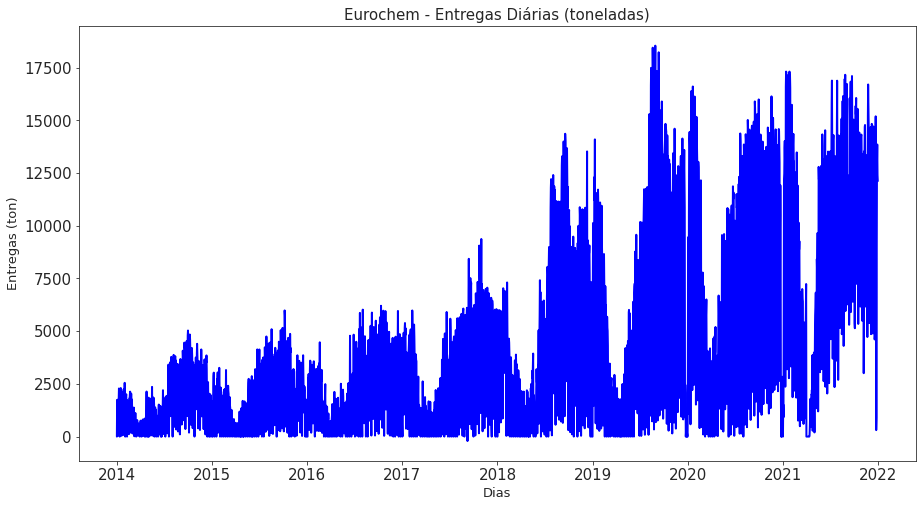

In [ ]:
Dtot = sns.lineplot(x=df1.index[:], y = df1['Deliveries'][:], color = 'blue', dashes=df1['Deliveries'])
Dtot.set_title('Eurochem - Entregas Diárias (toneladas)', fontsize = 15)
Dtot.set_ylabel('Entregas (ton)', fontsize = 13)
Dtot.set_xlabel('Dias', fontsize = 13)
plt.show()

In [ ]:
#1
dSLO = sns.lineplot(x=df1_SLO.index[:], y = df1_SLO['Deliveries'][:], color = 'blue', dashes=df1_SLO['Deliveries'])
dSLO.set_title('São Luís - Entregas Diárias (toneladas)', fontsize = 15)
dSLO.set_ylabel('Entregas (ton)', fontsize = 13)
dSLO.set_xlabel('Dias', fontsize = 13)
plt.show()

In [ ]:
#2
dSLO = sns.lineplot(x=df1_SLO.index[-365:], y = df1_SLO['Deliveries'][-365:], color = 'blue', dashes=df1_SLO['Deliveries'])
dSLO.set_title('São Luís - Entregas Diárias em 2021 (toneladas)', fontsize = 15)
dSLO.set_ylabel('Entregas (ton)', fontsize = 13)
dSLO.set_xlabel('Dias', fontsize = 13)
plt.show()

#### sARIMA

In [ ]:
# Seasonal Decompose das Entregas Diárias
result_deliveriesd_SLO = seasonal_decompose(treino_d1SLO['Deliveries'][-365:], model='additive', freq=7)
result_deliveriesd_SLO.plot()
pyplot.show()

In [ ]:
result_m = adfuller(df1_SLO['Deliveries'], autolag='AIC')
print(f'Estatítica de Dickey-Fuller: {result_m[0]} \n')
print(f'p-Valor: {result_m[1]}')
for key, value in result_m[4].items():
  print('\t%s: %.3f' % (key,value))

In [ ]:
lags = 120
title1 = 'Autocorrelação: Entregas Diárias em São Luís'
plot_acf(df1_SLO['Deliveries'],title=title1,lags=lags);

In [ ]:
title2 = 'Autocorrelação Parcial: Entregas Diárias em São Luís'
plot_pacf(df1_SLO['Deliveries'],title=title2,lags=lags);

In [ ]:
auto_arima(treino_d1SLO['Deliveries'],seasonal=True,m=7)
stepwise_fit = auto_arima(treino_d1SLO['Deliveries'], start_p=0, start_q=0, max_p=6, max_q=3, m=7,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

In [ ]:
sARIMA_d1SLO = SARIMAX(treino_d1SLO['Deliveries'],order=(6,1,0),seasonal_order=(1,0,2,7))
resultado_d1SLO = sARIMA_d1SLO.fit()

In [ ]:
inicio = len(treino_d1SLO)
fim = len(treino_d1SLO)+len(teste_d1SLO)-1
predito_sARIMA_d1SLO = resultado_d1SLO.predict(start=inicio, end=fim, dynamic=False, typ='levels').rename('Previsão sARIMA(5,1,1)(2,0,1,7')
predito_sARIMA_d1SLO.index = teste_d1SLO.index
treino_d1SLO['Deliveries'][-400:].plot(legend=True,label='Treino')
teste_d1SLO['Deliveries'].plot(legend=True,label='Teste')
predito_sARIMA_d1SLO.plot(legend=True,label='Predito')
plt.title('São Luís - Modelo de Previsão de Entregas Diárias (ton)')
plt.show()

In [ ]:
MAPE_sARIMA_d1SLO = round(100*mean_absolute_percentage_error(teste_d1SLO['Deliveries'],predito_sARIMA_d1SLO),2)
print(f'Mean Absolute Percentage Error: MAPE = {MAPE_sARIMA_d1SLO}%')

#### Holt-Winters

In [ ]:
modelo_d1SLO_HW = ExponentialSmoothing(treino_d1SLO['Deliveries'],trend='add',seasonal='add',seasonal_periods=7).fit();
treino_d1SLO['HoltWinters'] = modelo_d1SLO_HW.fittedvalues
treino_d1SLO['Deliveries'].plot(legend=True,label='Entregas')
treino_d1SLO['HoltWinters'].plot(legend=True,label='HW')
plt.show()

In [ ]:
predito_HW_d1SLO = modelo_d1SLO_HW.forecast(7).rename('Previsão SLO HW')

In [ ]:
treino_d1SLO['Deliveries'][-360:].plot(legend=True,label='Entregas (BASE TREINO)')
teste_d1SLO['Deliveries'].plot(legend=True,label='Entregas (BASE TESTE)')
predito_HW_d1SLO.plot(legend=True,label='Previsão Holt-Winters')
plt.title('Previsão de Holt-Winters para Entregas de São Luís')
plt.show()

In [ ]:
MAPE_HW_d1SLO = round(100*mean_absolute_percentage_error(teste_d1SLO['Deliveries'],predito_HW_d1SLO),2)
print(f'Mean Absolute Percentage Error: MAPE = {MAPE_HW_d1SLO}%')

#### Método Theta


In [ ]:
modelo_d1SLO_TM = ThetaModel(treino_d1SLO['Deliveries']).fit()
print(modelo_d1SLO_TM.summary())

In [ ]:
modelo_d1SLO_TM = ThetaModel(treino_d1SLO['Deliveries'], deseasonalize=True, period=7).fit()
predito_d1SLO_TM = modelo_d1SLO_TM.forecast(7)

In [ ]:
plt.plot(predito_d1SLO_TM, color='red', label='Previsão Modelo Theta')
plt.plot(treino_d1SLO['Deliveries'][-360:], color='blue', label='Treino')
plt.plot(teste_d1SLO['Deliveries'], color='green', label='Teste')
plt.title('Previsão através do Modelo Theta')
plt.legend()
plt.show()

In [ ]:
MAPE_TM_d1SLO = round(100*mean_absolute_percentage_error(teste_d1SLO['Deliveries'],predito_d1SLO_TM),2)
print(f'Mean Absolute Percentage Error: MAPE = {MAPE_TM_d1SLO}%')

### **Entregas Mensais**

In [ ]:
#8
mSLO = sns.lineplot(x=dm1_SLO.index[:], y = dm1_SLO['Deliveries'][:], color = 'blue', dashes=dm1_SLO['Deliveries'])
mSLO.set_title('São Luís - Entregas Mensais (toneladas)', fontsize = 15)
mSLO.set_ylabel('Entregas (ton)', fontsize = 13)
mSLO.set_xlabel('Dias', fontsize = 13)
plt.show()

In [ ]:
#9
# Seasonal Decompose das Entregas Diárias
result_deliveriesm_SLO = seasonal_decompose(treino_m1SLO['Deliveries'], model='additive', freq=12)
result_deliveriesm_SLO.plot()
pyplot.show()

In [ ]:
#10
lags = 36
title1 = 'Autocorrelação: Entregas Mensais em São Luís'
plot_acf(dm1_SLO['Deliveries'],title=title1,lags=lags);

In [ ]:
#11
title2 = 'Autocorrelação Parcial: Entregas Mensais em São Luís'
plot_pacf(dm1_SLO['Deliveries'],title=title2,lags=lags);

In [ ]:
result_m = adfuller(dm1_SLO['Deliveries'], autolag='AIC')
print(f'Estatítica de Dickey-Fuller para a série original: {result_m[0]} \n')
print(f'p-Valor: {result_m[1]}')
for key, value in result_m[4].items():
  print('\t%s: %.3f' % (key,value))

In [ ]:
result_m_diff = adfuller(np.diff(dm1_SLO['Deliveries']), autolag='AIC')
print(f'Estatítica de Dickey-Fuller para a série original: {result_m_diff[0]} \n')
print(f'p-Valor: {result_m_diff[1]}')
for key, value in result_m_diff[4].items():
  print('\t%s: %.3f' % (key,value))

In [ ]:
auto_arima(treino_m1SLO['Deliveries'],seasonal=True,m=12)
stepwise_fit = auto_arima(treino_m1SLO['Deliveries'], start_p=0, start_q=0, max_p=6, max_q=3, m=12,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

In [ ]:
#sARIMA_m1SLO = SARIMAX(treino_m1SLO['Deliveries'],order=(0,1,1),seasonal_order=(2,0,0,6))
sARIMA_m1SLO = SARIMAX(treino_m1SLO['Deliveries'],order=(1,0,0),seasonal_order=(0,1,1,12))
resultado_m1SLO = sARIMA_m1SLO.fit()

In [ ]:
#12
inicio = len(treino_m1SLO)
fim = len(treino_m1SLO)+len(teste_m1SLO)-1
predito_sARIMA_m1SLO = resultado_m1SLO.predict(start=inicio, end=fim, dynamic=False, typ='levels').rename('Previsão sARIMA(5,1,1)(2,0,1,7')
predito_sARIMA_m1SLO.index = teste_m1SLO.index
treino_m1SLO['Deliveries'].plot(legend=True,label='Treino')
teste_m1SLO['Deliveries'].plot(legend=True,label='Teste')
predito_sARIMA_m1SLO.plot(legend=True,label='Predito')
plt.title('São Luís - Modelo de Previsão de Entregas Mensais (ton)')
plt.show()

In [ ]:
MAPE_sARIMA_m1SLO = round(100*mean_absolute_percentage_error(teste_m1SLO['Deliveries'],predito_sARIMA_m1SLO),2)
print(f'sARIMA: Mean Absolute Percentage Error MAPE = {MAPE_sARIMA_m1SLO}%')

In [ ]:
modelo_m1SLO_HW = ExponentialSmoothing(treino_m1SLO['Deliveries'],trend='add',seasonal='add',seasonal_periods=12).fit();
treino_m1SLO['HoltWinters'] = modelo_m1SLO_HW.fittedvalues
treino_m1SLO['Deliveries'].plot(legend=True,label='Entregas')
treino_m1SLO['HoltWinters'].plot(legend=True,label='HW')
plt.show()

In [ ]:
predito_m1SLO_HW = modelo_m1SLO_HW.forecast(5).rename('Previsão slo m HW')

In [ ]:
treino_m1SLO['Deliveries'].plot(legend=True,label='Entregas (BASE TREINO)')
teste_m1SLO['Deliveries'].plot(legend=True,label='Entregas (BASE TESTE)')
predito_m1SLO_HW.plot(legend=True,label='Previsão Holt-Winters')
plt.title('Previsão de Holt-Winters para Entregas de São Luís')
plt.show()

In [ ]:
MAPE_m1SLO_HW = round(100*mean_absolute_percentage_error(teste_m1SLO['Deliveries'],predito_m1SLO_HW),2)
print(f'Holt-Winter: Mean Absolute Percentage Error MAPE = {MAPE_m1SLO_HW}%')

### **Entregas Mensais de Cloreto de Potássio _KCL_**

In [ ]:
mSLO_MP1 = sns.lineplot(x=dm2_SLO_MP1.index[:], y = dm2_SLO_MP1['Quantity'][:], color = 'red', dashes=dm2_SLO_MP1['Quantity'])
mSLO_MP1.set_title('São Luís - Entregas Mensais de Cloreto de Potássio (toneladas)', fontsize = 15)
mSLO_MP1.set_ylabel('Entregas (ton)', fontsize = 13)
mSLO_MP1.set_xlabel('Dias', fontsize = 13)
plt.show()

In [ ]:
# Seasonal Decompose das Entregas Mensais de Cloreto
result_deliveriesm_SLO_MP1 = seasonal_decompose(treino_m2SLO_MP1['Quantity'], model='additive', freq=12)
result_deliveriesm_SLO_MP1.plot()
pyplot.show()

In [ ]:
auto_arima(treino_m2SLO_MP1['Quantity'],seasonal=True,m=12)
stepwise_fit = auto_arima(treino_m2SLO_MP1['Quantity'], start_p=0, start_q=0, max_p=6, max_q=3, start_d=0, max_d=3, m=12,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=False)

In [ ]:
result_m = adfuller(dm2_SLO_MP1['Quantity'], autolag='AIC')
print(f'Estatítica de Dickey-Fuller para a série original: {result_m[0]} \n')
print(f'p-Valor: {result_m[1]}')
for key, value in result_m[4].items():
  print('\t%s: %.3f' % (key,value))

In [ ]:
result_m = adfuller(np.diff(dm2_SLO_MP1['Quantity']), autolag='AIC')
print(f'Estatítica de Dickey-Fuller para a série original: {result_m[0]} \n')
print(f'p-Valor: {result_m[1]}')
for key, value in result_m[4].items():
  print('\t%s: %.3f' % (key,value))

In [ ]:
sns.set_style('whitegrid')
lags = 36
title1 = 'Autocorrelação: Entregas Mensais de Cloreto em São Luís'
plot_acf(dm2_SLO_MP1['Quantity'],title=title1,lags=lags);

In [ ]:
##sARIMA_m2SLO_MP1 = SARIMAX(treino_m2SLO_MP1['Quantity'],order=(2,0,2),seasonal_order=(2,0,2,6))
sARIMA_m2SLO_MP1 = SARIMAX(treino_m2SLO_MP1['Quantity'],order=(0,1,0),seasonal_order=(1,1,0,12))
resultado_m2SLO_MP1 = sARIMA_m2SLO_MP1.fit()

In [ ]:
inicio = len(treino_m2SLO_MP1)
fim = len(treino_m2SLO_MP1)+len(teste_m2SLO_MP1)-1
predito_sARIMA_m2SLO_MP1 = resultado_m2SLO_MP1.predict(start=inicio, end=fim, dynamic=False, typ='levels').rename('Previsão sARIMA(2,0,2)(2,0,2,6')
predito_sARIMA_m2SLO_MP1.index = teste_m2SLO_MP1.index
treino_m2SLO_MP1['Quantity'].plot(legend=True,label='Treino')
teste_m2SLO_MP1['Quantity'].plot(legend=True,label='Teste')
predito_sARIMA_m2SLO_MP1.plot(legend=True,label='Predito')
plt.title('São Luís - Modelo de Previsão de Entregas Mensais de Cloreto de Potássio (ton)')
plt.show()

In [ ]:
MAPE_sARIMA_m2SLO_MP1 = round(100*mean_absolute_percentage_error(teste_m2SLO_MP1['Quantity'],predito_sARIMA_m2SLO_MP1),2)
print(f'sARIMA: Mean Absolute Percentage Error MAPE = {MAPE_sARIMA_m2SLO_MP1}%')

In [ ]:
modelo_m2SLO_MP1_HW = ExponentialSmoothing(treino_m2SLO_MP1['Quantity'],trend='add',seasonal='add',seasonal_periods=12).fit();
treino_m2SLO_MP1['HoltWinters'] = modelo_m2SLO_MP1_HW.fittedvalues
treino_m2SLO_MP1['Quantity'].plot(legend=True,label='Entregas')
treino_m2SLO_MP1['HoltWinters'].plot(legend=True,label='HW')
plt.show()

In [ ]:
predito_m2SLO_MP1_HW = modelo_m2SLO_MP1_HW.forecast(4).rename('Previsão slo m HW')

In [ ]:
treino_m2SLO_MP1['Quantity'].plot(legend=True,label='Entregas (BASE TREINO)')
teste_m2SLO_MP1['Quantity'].plot(legend=True,label='Entregas (BASE TESTE)')
predito_m2SLO_MP1_HW.plot(legend=True,label='Previsão Holt-Winters')
plt.title('Previsão de Holt-Winters para Entregas Mensais de Cloreto de Potássio em São Luís')
plt.show()

In [ ]:
MAPE_HW_m2SLO_MP1 = round(100*mean_absolute_percentage_error(teste_m2SLO_MP1['Quantity'],predito_m2SLO_MP1_HW),2)
print(f'sARIMA: Mean Absolute Percentage Error MAPE = {MAPE_HW_m2SLO_MP1}%')

In [ ]:
modelo_m2SLO_MP1_TM = ThetaModel(treino_m2SLO_MP1['Quantity']).fit()
print(modelo_m2SLO_MP1_TM.summary())

In [ ]:
modelo_m2SLO_MP1_TM = ThetaModel(treino_m2SLO_MP1['Quantity'], deseasonalize=True, period=12).fit()
predito_m2SLO_MP1_TM = modelo_m2SLO_MP1_TM.forecast(4)

In [ ]:
MAPE_m2SLO_MP1_TM = round(100*mean_absolute_percentage_error(teste_m2SLO_MP1['Quantity'],predito_m2SLO_MP1_TM),2)
print(f'sARIMA: Mean Absolute Percentage Error MAPE = {MAPE_m2SLO_MP1_TM}%')

In [ ]:
nicio = len(treino_m2SLO_MP1)
fim = len(treino_m2SLO_MP1)+len(teste_m2SLO_MP1)-1
predito_sARIMA_m2SLO_MP1 = resultado_m2SLO_MP1.predict(start=inicio, end=fim, dynamic=False, typ='levels').rename('Previsão sARIMA(2,0,2)(2,0,2,6')
predito_sARIMA_m2SLO_MP1.index = teste_m2SLO_MP1.index
treino_m2SLO_MP1['Quantity'].plot(legend=True,label='Treino')
teste_m2SLO_MP1['Quantity'].plot(legend=True,label='Teste')
predito_sARIMA_m2SLO_MP1.plot(legend=True,label='sARIMA',linestyle=':')
predito_m2SLO_MP1_HW.plot(legend=True,label='HW',linestyle=':')
predito_m2SLO_MP1_TM.plot(legend=True,label='TM',linestyle=':')
plt.title('São Luís - Modelo de Previsão de Entregas Mensais de Cloreto de Potássio (ton)')
plt.show()

### **Entregas Mensais de Ureia**

In [ ]:
sns.set_style('white')
mSLO_MP2 = sns.lineplot(x=dm2_SLO_MP2.index[:], y = dm2_SLO_MP2['Quantity'][:], color = 'red', label='Ureia')
mSLO_MP1 = sns.lineplot(x=dm2_SLO_MP1.index[:], y = dm2_SLO_MP1['Quantity'][:], color = 'green', linestyle='--',label='Cloreto')
mSLO_MP2.set_title('São Luís - Entregas Mensais de Ureia e Comparação com Entregas de Cloreto (toneladas)', fontsize = 15)
mSLO_MP2.set_ylabel('Entregas (ton)', fontsize = 13)
mSLO_MP2.set_xlabel('Dias', fontsize = 13)
plt.show()

In [ ]:
# Seasonal Decompose das Entregas Mensais de Ureia
result_deliveriesm_SLO_MP2 = seasonal_decompose(treino_m2SLO_MP2['Quantity'], model='additive', freq=12)
result_deliveriesm_SLO_MP2.plot()
pyplot.show()

In [ ]:
auto_arima(treino_m2SLO_MP2['Quantity'],seasonal=True,m=12)
stepwise_fit = auto_arima(treino_m2SLO_MP2['Quantity'], start_p=0, start_q=0, start_d = 0, max_p=10, max_q=10, max_d=6, m=12,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

In [ ]:
result_m = adfuller(dm2_SLO_MP2['Quantity'], autolag='AIC')
print(f'Estatítica de Dickey-Fuller para a série original: {result_m[0]} \n')
print(f'p-Valor: {result_m[1]}')
for key, value in result_m[4].items():
  print('\t%s: %.3f' % (key,value))

In [ ]:
sns.set_style('whitegrid')
lags = 36
title1 = 'Autocorrelação: Entregas Mensais de Ureia em São Luís'
plot_acf(dm2_SLO_MP2['Quantity'],title=title1,lags=lags);

In [ ]:
sARIMA_m2SLO_MP2 = SARIMAX(treino_m2SLO_MP2['Quantity'],order=(1,0,0),seasonal_odrer=(2,0,1,12))
resultado_m2SLO_MP2 = sARIMA_m2SLO_MP2.fit()

In [ ]:
inicio = len(treino_m2SLO_MP2)
fim = len(treino_m2SLO_MP2)+len(teste_m2SLO_MP2)-1
predito_sARIMA_m2SLO_MP2 = resultado_m2SLO_MP2.predict(start=inicio, end=fim, dynamic=False, typ='levels').rename('Previsão sARIMA(0,0,1)(2,0,1,6')
predito_sARIMA_m2SLO_MP2.index = teste_m2SLO_MP2.index
treino_m2SLO_MP2['Quantity'].plot(legend=True,label='Treino')
teste_m2SLO_MP2['Quantity'].plot(legend=True,label='Teste')
predito_sARIMA_m2SLO_MP2.plot(legend=True,label='Predito')
plt.title('São Luís - Modelo de Previsão de Entregas Mensais de Ureia (ton)')
plt.show()

In [ ]:
MAPE_sARIMA_m2SLO_MP2 = round(100*mean_absolute_percentage_error(teste_m2SLO_MP2['Quantity'],predito_sARIMA_m2SLO_MP2),2)
print(f'sARIMA: Mean Absolute Percentage Error MAPE = {MAPE_sARIMA_m2SLO_MP2}%')

In [ ]:
modelo_m2SLO_MP2_TM = ThetaModel(treino_m2SLO_MP2['Quantity']).fit()
print(modelo_m2SLO_MP2_TM.summary())

In [ ]:
modelo_m2SLO_MP2_TM = ThetaModel(treino_m2SLO_MP2['Quantity'], deseasonalize=True, period=12).fit()
predito_m2SLO_MP2_TM = modelo_m2SLO_MP2_TM.forecast(4)

In [ ]:
MAPE_m2SLO_MP2_TM = round(100*mean_absolute_percentage_error(teste_m2SLO_MP2['Quantity'],predito_m2SLO_MP2_TM),2)
print(f'TM: Mean Absolute Percentage Error MAPE = {MAPE_m2SLO_MP2_TM}%')

In [ ]:
modelo_m2SLO_MP2_HW = ExponentialSmoothing(treino_m2SLO_MP2['Quantity'],trend='add',seasonal='add',seasonal_periods=12).fit();
treino_m2SLO_MP2['HoltWinters'] = modelo_m2SLO_MP2_HW.fittedvalues
treino_m2SLO_MP2['Quantity'].plot(legend=True,label='Entregas', color='darkblue')
treino_m2SLO_MP2['HoltWinters'].plot(legend=True,label='Fit HW',color='green',linestyle=':')
plt.title('Fit do Modelo Holt-Winters à Série Temporal de Consumo de Ureia')
plt.ylabel('Entregas (ton)')
plt.show()

In [ ]:
predito_m2SLO_MP2_HW = modelo_m2SLO_MP2_HW.forecast(4).rename('Previsão SLO Ureia HW')

In [ ]:
MAPE_m2SLO_MP2_HW = round(100*mean_absolute_percentage_error(teste_m2SLO_MP2['Quantity'],predito_m2SLO_MP2_HW),2)
print(f'sARIMA: Mean Absolute Percentage Error MAPE = {MAPE_m2SLO_MP2_HW}%')

In [ ]:
sns.set_style('whitegrid')
treino_m2SLO_MP2['Quantity'].plot(legend=True,label='Entregas (Treino)',color='darkblue')
teste_m2SLO_MP2['Quantity'].plot(legend=True,label='Entregas (Teste)',color='red')
predito_m2SLO_MP2_HW.plot(legend=True,label='Previsão Holt-Winters', linestyle=':',color='green')
plt.title('Previsão de Holt-Winters para Entregas Mensais de Ureia em São Luís')
plt.show()

### **Entregas Mensais de MAP**

In [ ]:
mSLO_MP3 = sns.lineplot(x=dm2_SLO_MP3.index[:], y = dm2_SLO_MP3['Quantity'][:], color = 'red', dashes=dm2_SLO_MP3['Quantity'])
mSLO_MP3.set_title('São Luís - Entregas Mensais de MAP (toneladas)', fontsize = 15)
mSLO_MP3.set_ylabel('Entregas (ton)', fontsize = 13)
mSLO_MP3.set_xlabel('Dias', fontsize = 13)
plt.show()

In [ ]:
sns.set_style('whitegrid')
lags = 36
title1 = 'Autocorrelação: Entregas Mensais de MAP em São Luís'
plot_acf(dm2_SLO_MP3['Quantity'],title=title1,lags=lags);

In [ ]:
result_m = adfuller(dm2_SLO_MP3['Quantity'], autolag='AIC')
print(f'Estatítica de Dickey-Fuller para a série original: {result_m[0]} \n')
print(f'p-Valor: {result_m[1]}')
for key, value in result_m[4].items():
  print('\t%s: %.3f' % (key,value))

In [ ]:
auto_arima(treino_m2SLO_MP3['Quantity'],seasonal=True,m=12)
stepwise_fit = auto_arima(treino_m2SLO_MP3['Quantity'], start_p=0, start_q=0, start_d = 0, max_p=6, max_q=6, max_d=6, m=12,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

In [ ]:
sARIMA_m2SLO_MP3 = SARIMAX(treino_m2SLO_MP3['Quantity'],order=(1,0,0),seasonal_order=(2,0,0,12))
resultado_m2SLO_MP3 = sARIMA_m2SLO_MP3.fit()

In [ ]:
inicio = len(treino_m2SLO_MP3)
fim = len(treino_m2SLO_MP3)+len(teste_m2SLO_MP3)-1
predito_sARIMA_m2SLO_MP3 = resultado_m2SLO_MP3.predict(start=inicio, end=fim, dynamic=False, typ='levels').rename('Previsão sARIMA(0,0,1)(2,0,1,6')
predito_sARIMA_m2SLO_MP3.index = teste_m2SLO_MP3.index
treino_m2SLO_MP3['Quantity'].plot(legend=True,label='Treino')
teste_m2SLO_MP3['Quantity'].plot(legend=True,label='Teste')
predito_sARIMA_m2SLO_MP3.plot(legend=True,label='Predito')
plt.title('São Luís - Modelo de Previsão de Entregas Mensais de MAP (ton)')
plt.show()

In [ ]:
MAPE_sARIMA_m2SLO_MP3 = round(100*mean_absolute_percentage_error(teste_m2SLO_MP3['Quantity'],predito_sARIMA_m2SLO_MP3),2)
print(f'sARIMA: Mean Absolute Percentage Error MAPE = {MAPE_sARIMA_m2SLO_MP3}%')

In [ ]:
modelo_m2SLO_MP3_HW = ExponentialSmoothing(treino_m2SLO_MP3['Quantity'],trend='add',seasonal='add',seasonal_periods=12).fit();
treino_m2SLO_MP3['HoltWinters'] = modelo_m2SLO_MP3_HW.fittedvalues
treino_m2SLO_MP3['Quantity'].plot(legend=True,label='Entregas', color='darkblue')
treino_m2SLO_MP3['HoltWinters'].plot(legend=True,label='Fit HW',color='green',linestyle=':')
plt.title('Fit do Modelo Holt-Winters à Série Temporal de Consumo de Ureia')
plt.ylabel('Entregas (ton)')
plt.show()

### **Entregas Mensais de TSP**

In [ ]:
mSLO_MP4 = sns.lineplot(x=dm2_SLO_MP4.index[:], y = dm2_SLO_MP4['Quantity'][:], color = 'red', dashes=dm2_SLO_MP4['Quantity'])
mSLO_MP4.set_title('São Luís - Entregas Mensais de TSP (toneladas)', fontsize = 15)
mSLO_MP4.set_ylabel('Entregas (ton)', fontsize = 13)
mSLO_MP4.set_xlabel('Dias', fontsize = 13)
plt.show()

In [ ]:
sns.set_style('whitegrid')
lags = 36
title1 = 'Autocorrelação: Entregas Mensais de TSP em São Luís'
plot_acf(dm2_SLO_MP4['Quantity'],title=title1,lags=lags);

In [ ]:
result_m = adfuller(dm2_SLO_MP4['Quantity'], autolag='AIC')
print(f'Estatítica de Dickey-Fuller para a série original: {result_m[0]} \n')
print(f'p-Valor: {result_m[1]}')
for key, value in result_m[4].items():
  print('\t%s: %.3f' % (key,value))

In [ ]:
auto_arima(treino_m2SLO_MP4['Quantity'],seasonal=True,m=6)
stepwise_fit = auto_arima(treino_m2SLO_MP4['Quantity'], start_p=0, start_q=0, start_d = 0, max_p=6, max_q=6, max_d=6, m=6,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

In [ ]:
sARIMA_m2SLO_MP4 = SARIMAX(treino_m2SLO_MP4['Quantity'],order=(1,0,0),seasonal_order=(2,0,0,6))
resultado_m2SLO_MP4 = sARIMA_m2SLO_MP4.fit()

In [ ]:
inicio = len(treino_m2SLO_MP4)
fim = len(treino_m2SLO_MP4)+len(teste_m2SLO_MP4)-1
predito_sARIMA_m2SLO_MP4 = resultado_m2SLO_MP4.predict(start=inicio, end=fim, dynamic=False, typ='levels').rename('Previsão sARIMA(0,0,1)(2,0,1,6')
predito_sARIMA_m2SLO_MP4.index = teste_m2SLO_MP4.index
treino_m2SLO_MP4['Quantity'].plot(legend=True,label='Treino')
teste_m2SLO_MP4['Quantity'].plot(legend=True,label='Teste')
predito_sARIMA_m2SLO_MP4.plot(legend=True,label='Predito')
plt.title('São Luís - Modelo de Previsão de Entregas Mensais de TSP (ton)')
plt.show()

In [ ]:
MAPE_sARIMA_m2SLO_MP4 = round(100*mean_absolute_percentage_error(teste_m2SLO_MP4['Quantity'],predito_sARIMA_m2SLO_MP4),2)
print(f'sARIMA: Mean Absolute Percentage Error MAPE = {MAPE_sARIMA_m2SLO_MP4}%')

### **Entregas Mensais de SSP**

In [ ]:
mSLO_MP5 = sns.lineplot(x=dm2_SLO_MP5.index[:], y = dm2_SLO_MP5['Quantity'][:], color = 'red', dashes=dm2_SLO_MP5['Quantity'])
mSLO_MP5.set_title('São Luís - Entregas Mensais de SSP (toneladas)', fontsize = 15)
mSLO_MP5.set_ylabel('Entregas (ton)', fontsize = 13)
mSLO_MP5.set_xlabel('Dias', fontsize = 13)
plt.show()

In [ ]:
sns.set_style('whitegrid')
lags = 36
title1 = 'Autocorrelação: Entregas Mensais de SSP em São Luís'
plot_acf(dm2_SLO_MP5['Quantity'],title=title1,lags=lags);

In [ ]:
result_m = adfuller(dm2_SLO_MP5['Quantity'], autolag='AIC')
print(f'Estatítica de Dickey-Fuller para a série original: {result_m[0]} \n')
print(f'p-Valor: {result_m[1]}')
for key, value in result_m[4].items():
  print('\t%s: %.3f' % (key,value))

In [ ]:
result_m = adfuller(np.diff(dm2_SLO_MP5['Quantity']), autolag='AIC')
print(f'Estatítica de Dickey-Fuller para a série original: {result_m[0]} \n')
print(f'p-Valor: {result_m[1]}')
for key, value in result_m[4].items():
  print('\t%s: %.3f' % (key,value))

In [ ]:
auto_arima(treino_m2SLO_MP5['Quantity'],seasonal=True,m=6)
stepwise_fit = auto_arima(treino_m2SLO_MP5['Quantity'], start_p=0, start_q=0, start_d = 0, max_p=6, max_q=6, max_d=6, m=6,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

In [ ]:
sARIMA_m2SLO_MP5 = SARIMAX(treino_m2SLO_MP5['Quantity'],order=(1,0,0),seasonal_order=(2,0,0,6))
resultado_m2SLO_MP5 = sARIMA_m2SLO_MP5.fit()

In [ ]:
inicio = len(treino_m2SLO_MP5)
fim = len(treino_m2SLO_MP5)+len(teste_m2SLO_MP5)-1
predito_sARIMA_m2SLO_MP5 = resultado_m2SLO_MP5.predict(start=inicio, end=fim, dynamic=False, typ='levels').rename('Previsão sARIMA(0,0,1)(2,0,1,6')
predito_sARIMA_m2SLO_MP5.index = teste_m2SLO_MP5.index
treino_m2SLO_MP5['Quantity'].plot(legend=True,label='Treino')
teste_m2SLO_MP5['Quantity'].plot(legend=True,label='Teste')
predito_sARIMA_m2SLO_MP5.plot(legend=True,label='Predito')
plt.title('São Luís - Modelo de Previsão de Entregas Mensais de SSP (ton)')
plt.show()

In [ ]:
MAPE_sARIMA_m2SLO_MP5 = round(100*mean_absolute_percentage_error(teste_m2SLO_MP5['Quantity'],predito_sARIMA_m2SLO_MP5),2)
print(f'sARIMA: Mean Absolute Percentage Error MAPE = {MAPE_sARIMA_m2SLO_MP5}%')

### _**Visualização Agregada**_

In [ ]:
plt.rc("figure",figsize=(15,8))
plt.rc("font",size=15)
plt.rc("lines",linewidth=2)
sns.set_style("darkgrid")

In [ ]:
dm2_SLO_MP345 = dm2_SLO_MP3.copy()

In [ ]:
for i in range(dm2_SLO_MP345.shape[0]):
  dm2_SLO_MP345['Quantity'][i] = dm2_SLO_MP345['Quantity'][i] + dm2_SLO_MP4['Quantity'][i] + dm2_SLO_MP5['Quantity'][i]

In [ ]:
mSLO = sns.lineplot(x=dm1_SLO.index[24:], y = dm1_SLO['Deliveries'][24:], color = 'blue', dashes=dm1_SLO['Deliveries'],
                    label = 'Entregas Totais')
##mSLO_MP1 = sns.lineplot(x=dm2_SLO_MP1.index[:], y = dm2_SLO_MP1['Quantity'][:], color = 'red', dashes=dm2_SLO_MP1['Quantity'],
##                        linestyle='--')
##mSLO_MP2 = sns.lineplot(x=dm2_SLO_MP2.index[:], y = dm2_SLO_MP2['Quantity'][:], color = 'green', dashes=dm2_SLO_MP2['Quantity'],
##                        linestyle=':')
mSLO_MP1 = plt.fill_between(dm2_SLO_MP1.index[:], dm2_SLO_MP1['Quantity'][:], color='purple',label='Cloreto')
mSLO_MP2 = plt.fill_between(dm2_SLO_MP2.index[:], dm2_SLO_MP2['Quantity'][:], color='darkblue',label='Ureia')
##mSLO_MP2 = sns.lineplot(x=dm2_SLO_MP2.index[:], y = dm2_SLO_MP2['Quantity'][:], color = 'green', dashes=dm2_SLO_MP2['Quantity'],
##                        linestyle=':')
mSLO_MP345 = sns.lineplot(x=dm2_SLO_MP345.index[:], y = dm2_SLO_MP345['Quantity'][:], color = 'red', dashes=dm2_SLO_MP345['Quantity'],
                        linestyle=':',label='Fosfatados')
mSLO.set_title('São Luís - Comparação entre Entregas Totais e Consumos de Matérias-Primas', fontsize = 15)
mSLO.set_ylabel('Entregas (ton)', fontsize = 13)
mSLO.set_xlabel('Meses', fontsize = 13)
plt.legend()
plt.show()

# _**Modelos**_

#### Modelo: **_Previsão de Entregas Diárias_**

In [ ]:
#7
modelo_d1SLO = SARIMAX(df1_SLO['Deliveries'],order=(6,1,0),seasonal_order=(1,0,2,7))
res_modelo_d1SLO = modelo_d1SLO.fit()
forecast_d1SLO = res_modelo_d1SLO.predict(len(df1_SLO),len(df1_SLO)+7,typ='levels').rename('São Luís - Forecast para Entregas Diárias')
df1_SLO['Deliveries'][-365:].plot(legend=True,label='Histórico de Entregas')
forecast_d1SLO.plot(legend=True,label='Forecast',color='green')
plt.title('São Luís - Forecast de Entregas Mensais: 7 dias')
plt.show()

In [ ]:
print(f'MAPE = {MAPE_sARIMA_d1SLO}%')

#### Modelo: **_Previsão de Entregas Mensais_**

In [ ]:
modelo_m1SLO = SARIMAX(dm1_SLO['Deliveries'],order=(0,1,1),seasonal_order=(2,0,0,6))
res_modelo_m1SLO = modelo_m1SLO.fit()
forecast_m1SLO = res_modelo_m1SLO.predict(len(dm1_SLO),len(dm1_SLO)+5,typ='levels').rename('São Luís - Forecast para Entregas Mensais')
dm1_SLO['Deliveries'].plot(legend=True,label='Histórico de Entregas')
forecast_m1SLO.plot(legend=True,label='Forecast')
plt.title('Araguari - Forecast de Entregas Mensais: 5 meses')
plt.show()

#### Modelo: **_Previsão de Entregas Mensais de Cloreto de Potássio_**

In [ ]:
modelo_m2SLO_MP1 = SARIMAX(dm2_SLO_MP1['Quantity'],order=(2,0,2),seasonal_order=(2,0,2,6))
res_modelo_m2SLO_MP1 = modelo_m2SLO_MP1.fit()
forecast_m2SLO_MP1 = res_modelo_m2SLO_MP1.predict(len(dm2_SLO_MP1),len(dm2_SLO_MP1)+4,typ='levels').rename('São Luís - Forecast para Entregas Mensais de Cloreto de Potássio')
dm2_SLO_MP1['Quantity'].plot(legend=True,label='Histórico de Entregas')
forecast_m2SLO_MP1.plot(legend=True,label='Forecast')
plt.title('Araguari - Forecast de Entregas Mensais de Cloreto de Potássio: 4 meses')
plt.show()

#### Modelo: **_Previsão de Entregas Mensais de Ureia_**

In [ ]:
modelo_m2SLO_MP2 = SARIMAX(dm2_SLO_MP2['Quantity'],order=(2,1,1),seasonal_order=(2,0,1,6))
res_modelo_m2SLO_MP2 = modelo_m2SLO_MP2.fit()
forecast_m2SLO_MP2 = res_modelo_m2SLO_MP2.predict(len(dm2_SLO_MP2),len(dm2_SLO_MP2)+3,typ='levels').rename('São Luís - Forecast para Entregas Mensais de Ureia')
dm2_SLO_MP2['Quantity'].plot(legend=True,label='Histórico de Entregas')
forecast_m2SLO_MP2.plot(legend=True,label='Forecast')
plt.title('Araguari - Forecast de Entregas Mensais de Ureia: 3 meses')
plt.show()

#### Modelo: **_Previsão de Entregas Mensais de MAP_**

In [ ]:
modelo_m2SLO_MP3 = SARIMAX(dm2_SLO_MP3['Quantity'],order=(2,0,2),seasonal_order=(2,0,2,6))
res_modelo_m2SLO_MP3 = modelo_m2SLO_MP3.fit()
forecast_m2SLO_MP3 = res_modelo_m2SLO_MP3.predict(len(dm2_SLO_MP3),len(dm2_SLO_MP3)+3,typ='levels').rename('São Luís - Forecast para Entregas Mensais de MAP')
dm2_SLO_MP3['Quantity'].plot(legend=True,label='Histórico de Entregas')
forecast_m2SLO_MP3.plot(legend=True,label='Forecast')
plt.title('São Luís - Forecast de Entregas Mensais de MAP: 3 meses')
plt.show()

#### Modelo: **_Previsão de Entregas Mensais de TSP_**

In [ ]:
modelo_m2SLO_MP4 = SARIMAX(dm2_SLO_MP4['Quantity'],order=(1,0,0),seasonal_order=(2,0,0,6))
res_modelo_m2SLO_MP4 = modelo_m2SLO_MP4.fit()
forecast_m2SLO_MP4 = res_modelo_m2SLO_MP4.predict(len(dm2_SLO_MP4),len(dm2_SLO_MP4)+3,typ='levels').rename('São Luís - Forecast para Entregas Mensais de TSP')
dm2_SLO_MP4['Quantity'].plot(legend=True,label='Histórico de Entregas')
forecast_m2SLO_MP4.plot(legend=True,label='Forecast')
plt.title('São Luís - Forecast de Entregas Mensais de TSP: 3 meses')
plt.show()

#### Modelo: **_Previsão de Entregas Mensais de SSP_**

In [ ]:
modelo_m2SLO_MP5 = SARIMAX(dm2_SLO_MP5['Quantity'],order=(1,0,0),seasonal_order=(2,0,0,6))
res_modelo_m2SLO_MP5 = modelo_m2SLO_MP5.fit()
forecast_m2SLO_MP5 = res_modelo_m2SLO_MP5.predict(len(dm2_SLO_MP5),len(dm2_SLO_MP5)+3,typ='levels').rename('São Luís - Forecast para Entregas Mensais de SSP')
dm2_SLO_MP5['Quantity'].plot(legend=True,label='Histórico de Entregas')
forecast_m2SLO_MP5.plot(legend=True,label='Forecast')
plt.title('São Luís - Forecast de Entregas Mensais de SSP: 3 meses')
plt.show()